## Part 1

### Task 1 - Data Attribute

In [ ]:
!pip install mne

In [3]:
import mne
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import spectrogram, stft

In [4]:
# Load the EDF file
EEG_data_file_path = '/content/data/h01.edf'

raw = mne.io.read_raw_edf(EEG_data_file_path, preload=True)

raw = raw.pick_types(meg=False, eeg=True, eog=False, exclude='bads')

raw.info


Extracting EDF parameters from /content/data/h01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 231249  =      0.000 ...   924.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


Measurement date,"June 23, 2003 16:14:37 GMT"
Experimenter,Unknown
Participant,DJZ
Digitized points,Not available
Good channels,19 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


### Task 2 - Preprocess the Data

In [5]:
raw.filter(l_freq=1.0, h_freq=None)

# 2. Low-pass filter
raw.filter(l_freq=None, h_freq=40.0)

# 3. Notch filter to remove power line noise (50 Hz and 60 Hz)
raw.notch_filter(freqs=[50, 60], picks='all')

# 4. Remove bad channels (if any)
# Remove bad channels
raw.interpolate_bads()

# 5. Independent Component Analysis (ICA) for removing artifacts
ica = mne.preprocessing.ICA(n_components=19, random_state=97, max_iter=800)
ica.fit(raw)
raw_corrected = raw.copy()
ica.apply(raw_corrected)
raw_corrected

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 83 samples (0.332 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Setting channel interpolation method to {'eeg': 'spline'}.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
<ipython-input-5-04ab6db0fd53>:11: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads()


Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components
Fitting ICA took 24.5s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components


Measurement date,"June 23, 2003 16:14:37 GMT"
Experimenter,Unknown
Participant,DJZ
Digitized points,Not available
Good channels,19 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


### Task 3 - Plot the Data

Using matplotlib as 2D backend.


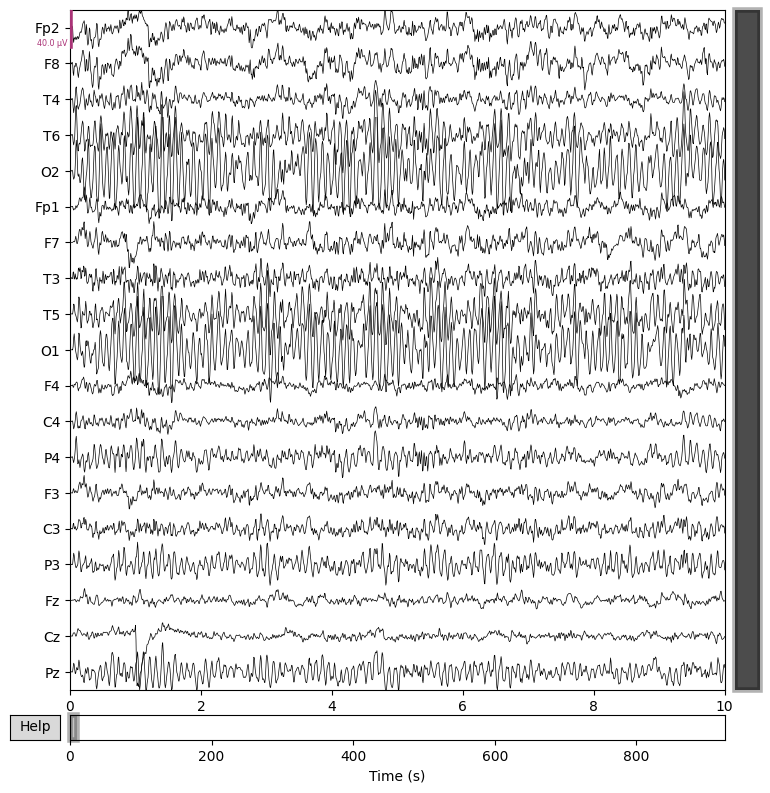

In [6]:
# Plot the data after preprocessing
raw_corrected.plot()
plt.show()

### Task 4 - Extract The Spectrogrum Pictures out of Signal

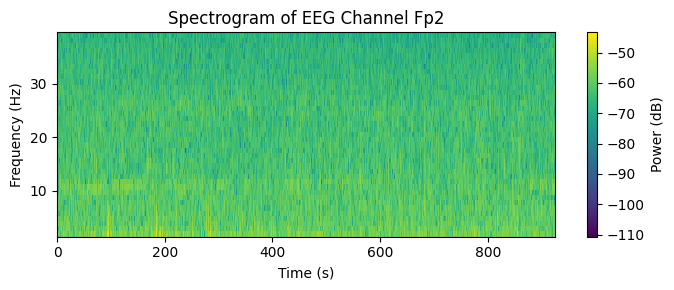

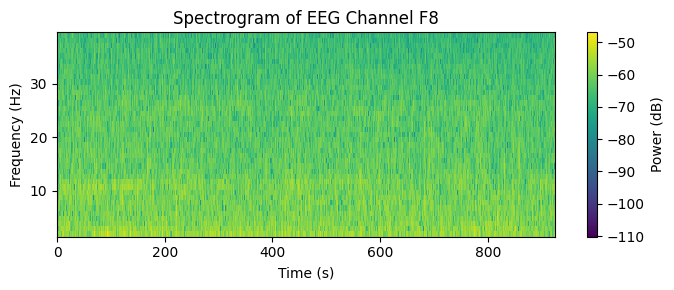

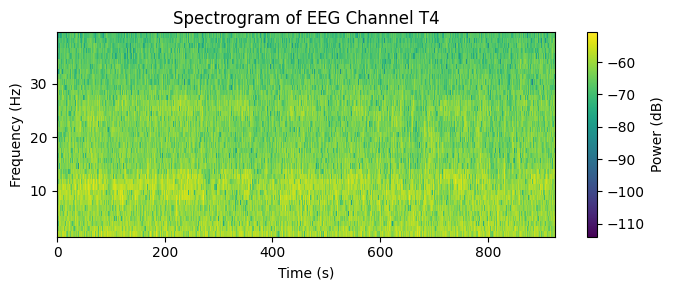

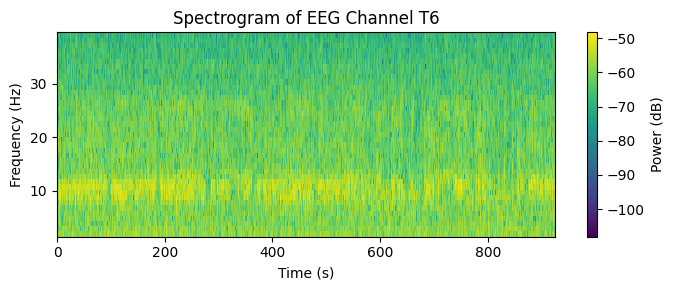

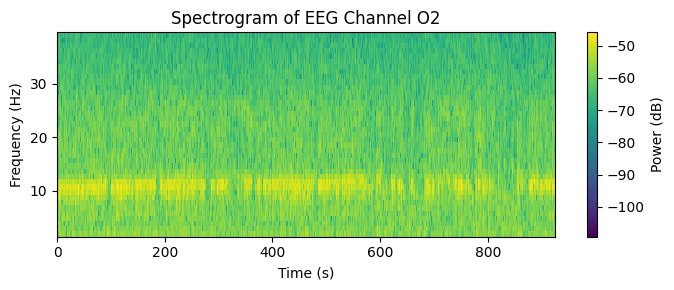

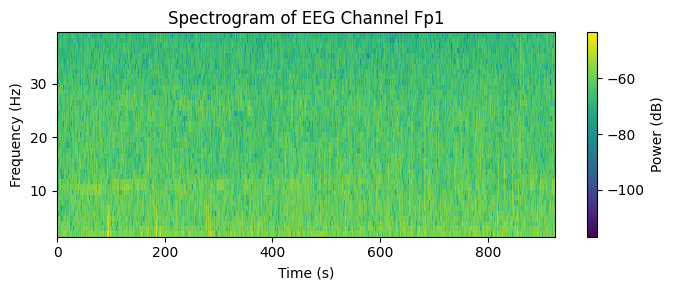

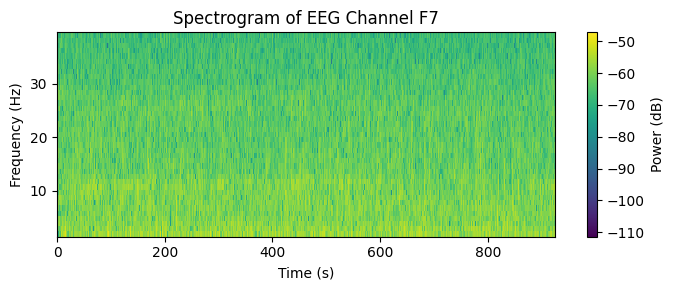

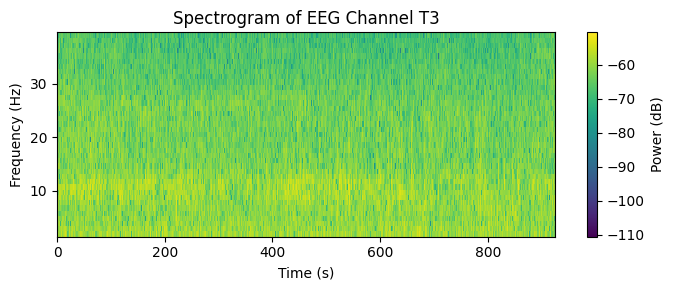

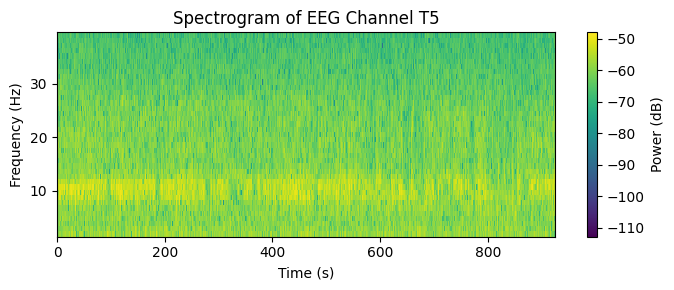

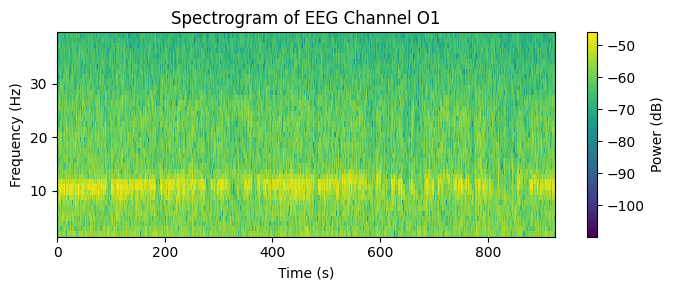

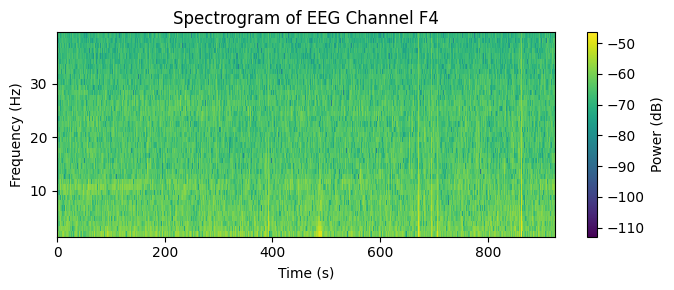

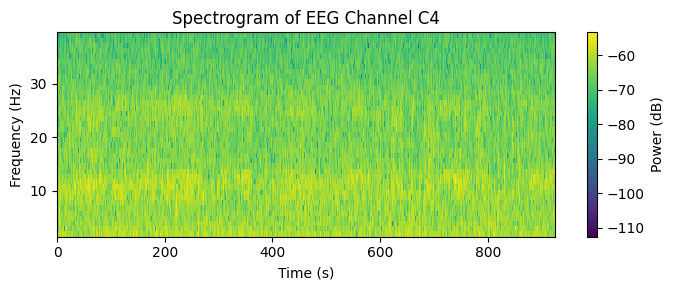

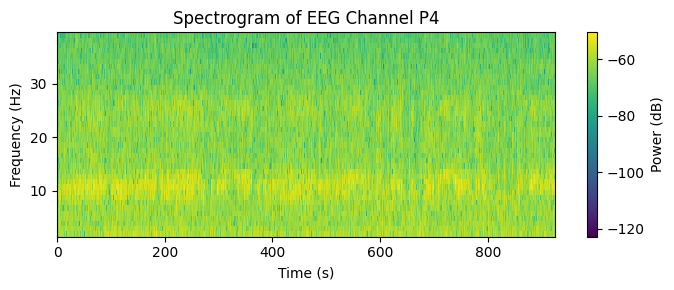

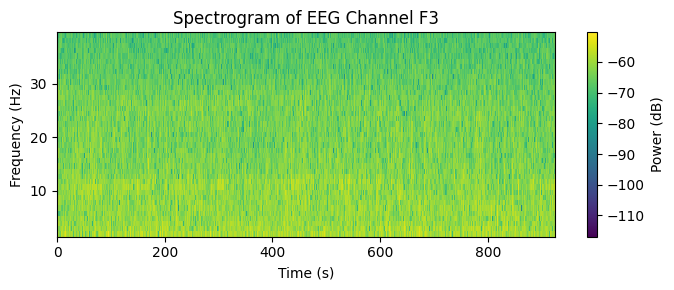

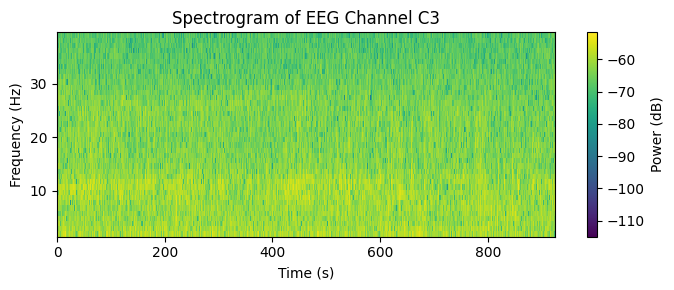

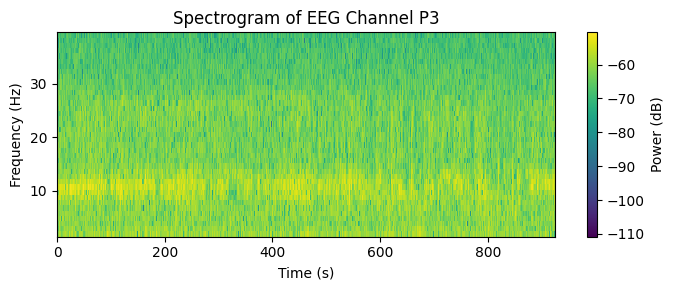

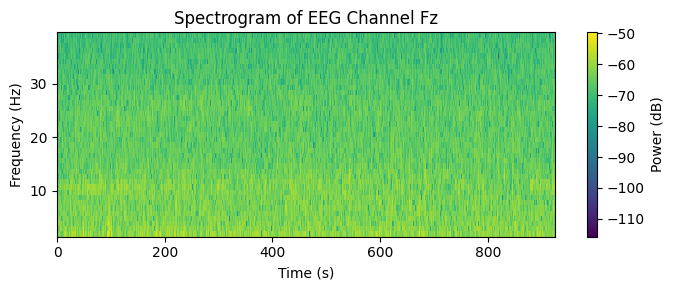

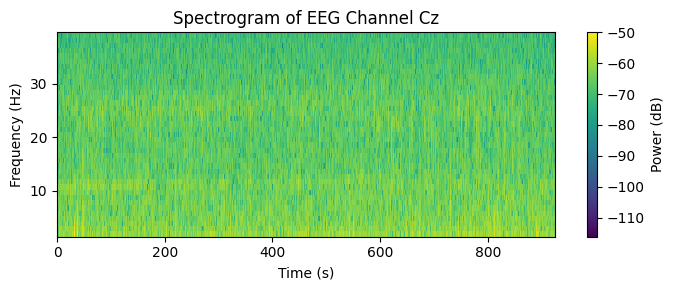

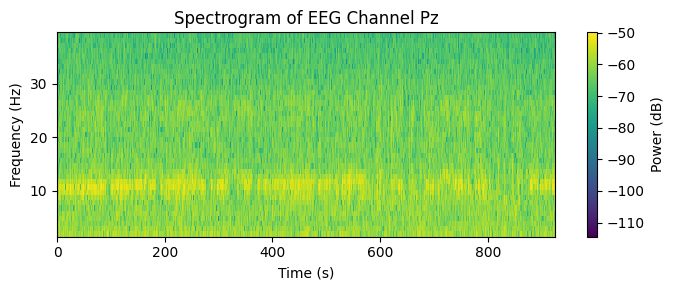

In [10]:
# get sfreq from EDF file
sfreq = raw_corrected.info.get('sfreq')

# convert data into numpy array
raw_corrected_data = raw_corrected.get_data()

# get number of channels
num_channels = raw_corrected_data.shape[0]

# filter data between 1 - 40 Hz ( base on data info )
freqs , times, Zxx = stft(raw_corrected_data, fs=sfreq, nperseg=256, noverlap=128)
fmin, fmax = 1, 40
freq_mask = (freqs >= fmin) & (freqs <= fmax)
Zxx = Zxx[:, freq_mask, :]

num_cols = 4  # Choose the number of columns for the grid
num_rows = int(np.ceil(num_channels / num_cols))
channel_list_names = raw_corrected.info.ch_names

# Plot spectrograms and save as PNG files

for i in range(num_channels):
    row_idx = i // num_cols
    col_idx = i % num_cols
    fig, ax = plt.subplots(figsize=(7, 3))
    pcm = ax.pcolormesh(times, freqs[freq_mask], 10 * np.log10(np.abs(Zxx[i])), cmap='viridis', shading='auto')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_xlabel('Time (s)')
    ax.set_title(f"Spectrogram of EEG Channel {channel_list_names[i]}")
    fig.colorbar(pcm, ax=ax, label="Power (dB)")
    plt.tight_layout()
    fig.savefig(f'/content/spectrogrum_data_of_h0/spectrogram_channel_{channel_list_names[i]}.png')
    plt.show()


## Part 2

### Task 1 & 3
- Design CNN Model For Spectrogrum Pictures
- Report Accuracy & F1-Score

In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from torchvision import models
from sklearn.metrics import f1_score, accuracy_score

In [9]:
torch.manual_seed(42)

# Set the path to the directory containing the saved spectrogram images
spectrogram_dir = '/content/spectrogrum_data_of_h0'

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

# Create a custom dataset
class SpectrogramDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = self._load_images()
        self.targets = [label for _, label in self.images]

    def _load_images(self):
        images = []
        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir)
            for filename in os.listdir(class_dir):
                img_path = os.path.join(class_dir, filename)
                images.append((img_path, class_idx))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, class_idx = self.images[idx]
        image = Image.open(img_path).convert("RGB")  # Convert to RGB for colorful images
        if self.transform:
            image = self.transform(image)

        return image, class_idx

# CNN Model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        resnet18 = models.resnet18(pretrained=True)
        resnet18.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.features = nn.Sequential(*list(resnet18.children())[:-1])
        self.fc = nn.Linear(512, num_classes)  # Adjust input size for your specific case

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Create datasets and dataloaders
dataset = SpectrogramDataset(spectrogram_dir, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# Extract the targets from the original dataset
train_targets = [label for _, label in train_dataset.dataset.images]
test_targets = [label for _, label in test_dataset.dataset.images]

batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the improved model, criterion, and optimizer
num_classes = len(dataset.classes)
model = CNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()

    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    predicted_train = []
    true_labels_train = []  # Store true labels for F1-score

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        predicted_train.extend(predicted.cpu().numpy())
        true_labels_train.extend(labels.cpu().numpy())

    avg_train_loss = total_train_loss / len(train_loader)
    accuracy_train = correct_train / total_train
    f1_train = f1_score(true_labels_train, predicted_train, average='weighted')

    # Evaluation on the test set
    model.eval()
    total_test_loss = 0.0
    correct_test = 0
    total_test = 0
    predicted_test = []
    true_labels_test = []  # Store true labels for F1-score

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            predicted_test.extend(predicted.cpu().numpy())
            true_labels_test.extend(labels.cpu().numpy())

    # Calculate average test loss
    avg_test_loss = total_test_loss / len(test_loader)
    accuracy_test = correct_test / total_test
    f1_test = f1_score(true_labels_test, predicted_test, average='weighted')

    print(f'Epoch [{epoch+1}/{num_epochs}], Avg. Training Loss: {avg_train_loss:.4f}, Train Accuracy: {accuracy_train * 100:.2f}%, Train F1-Score: {f1_train:.4f}, Avg. Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy_test * 100:.2f}%, Test F1-Score: {f1_test:.4f}')

    # Adjust the learning rate
    lr_scheduler.step()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 107MB/s]


Epoch [1/10], Avg. Training Loss: 3.5418, Train Accuracy: 3.12%, Train F1-Score: 0.0219, Avg. Test Loss: 3.2735, Test Accuracy: 5.48%, Test F1-Score: 0.0166
Epoch [2/10], Avg. Training Loss: 3.1728, Train Accuracy: 3.12%, Train F1-Score: 0.0198, Avg. Test Loss: 3.1645, Test Accuracy: 5.48%, Test F1-Score: 0.0193
Epoch [3/10], Avg. Training Loss: 3.0991, Train Accuracy: 5.21%, Train F1-Score: 0.0272, Avg. Test Loss: 3.1442, Test Accuracy: 1.37%, Test F1-Score: 0.0005
Epoch [4/10], Avg. Training Loss: 3.0782, Train Accuracy: 2.78%, Train F1-Score: 0.0101, Avg. Test Loss: 3.0541, Test Accuracy: 2.74%, Test F1-Score: 0.0087
Epoch [5/10], Avg. Training Loss: 3.0396, Train Accuracy: 3.12%, Train F1-Score: 0.0136, Avg. Test Loss: 3.0958, Test Accuracy: 1.37%, Test F1-Score: 0.0024
Epoch [6/10], Avg. Training Loss: 3.0072, Train Accuracy: 4.86%, Train F1-Score: 0.0196, Avg. Test Loss: 3.1374, Test Accuracy: 6.85%, Test F1-Score: 0.0160
Epoch [7/10], Avg. Training Loss: 2.9823, Train Accuracy: 

### Task 4 - Explain the Results


The provided training and testing results are from a deep learning model trained on a dataset using a Convolutional Neural Network (CNN) for image classification. The training and testing are conducted over 20 epochs, where each epoch represents a complete pass through the entire dataset during training. The reported metrics include the average training loss, training accuracy, training F1-score, average testing loss, testing accuracy, and testing F1-score.

In the first epoch, the model starts with a high training loss, low training accuracy, and a low training F1-score. Similarly, the testing metrics show a higher average testing loss, a low testing accuracy, and a low testing F1-score. As the training progresses, the model is attempting to learn patterns in the data, but the results indicate a struggle to achieve satisfactory performance. Notably, the testing accuracy remains low, indicating that the model struggles to generalize well to unseen data.

Across subsequent epochs, there are fluctuations in the training and testing metrics, but the overall trend shows limited improvement. The F1-score, which considers both precision and recall, is low for both training and testing, indicating challenges in correctly classifying samples from different classes. The model's struggle to learn meaningful representations is evident, and further investigation into model architecture, hyperparameters, and dataset characteristics may be necessary to improve performance.